# Model #2 Simple Linear Regression (Fuel->Forex)


* Import fuel_prices_com.csv & GBP_USD.csv






# Imports

In [ ]:
# Libraries
import pathlib
import numpy as np
import pandas as pd
# Graphs
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
# Checking for multicolinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import linregress
# Modeling metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Collection


In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
forex_dataset = pd.DataFrame(forex_dataset,columns=['Price','Date'])


In [ ]:
# Import fuel price
fuel_dataset = pd.read_csv('fuel_prices_com.csv', encoding= 'unicode_escape')
fuel_dataset = fuel_dataset.loc[fuel_dataset.Country=='USA', ['Date','Diesel', 'Brent oil price']]

In [ ]:
print(forex_dataset.shape),print(fuel_dataset.shape)

(214, 2)
(29, 3)


(None, None)

# Data Preprocessing / Data Cleaning & Collating


*   We first isolate the date column both fuel_dataset and forex_dataset so that they are formatted in the same way.  
*   Challenge: Fuel Price dataset is a weekly timeseries dataset whereas Forex Price is a daily timeseries dataset.




In [ ]:
# We first convert the value to a string datetime 
fuel_dataset['Date'] = fuel_dataset['Date'].apply(lambda x: pd.to_datetime(str(x)))
fuel_dataset['Date'].head()


772   2020-06-01
773   2020-01-13
774   2020-01-20
775   2020-01-27
776   2020-03-02
Name: Date, dtype: datetime64[ns]

In [ ]:
# We find out the format for where the day, month and year lie.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%b %d, %Y")
# We transform these values to the same format.
fuel_dataset["Date"] = fuel_dataset["Date"].dt.strftime("%d-%m-%Y")
forex_dataset["Date"] = forex_dataset["Date"].dt.strftime("%d-%m-%Y")
# We then convert them back to a dataframe.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%d-%m-%Y")

In [ ]:
# We set the index for both datasets to be date.
forex_dataset.set_index("Date", inplace=True)
fuel_dataset.set_index("Date", inplace=True)
forex_dataset["Date"] = forex_dataset.index
fuel_dataset["date"] = fuel_dataset.index

In [ ]:
# We then group these dates in a weekly period column
fuel_dataset["week"] = fuel_dataset.index.to_period('W')
forex_dataset["week"] = forex_dataset.index.to_period('W')

In [ ]:
# We then join our datasets on the week column
data_ff = pd.merge(
    forex_dataset,
    fuel_dataset,
    left_on="week",
    right_on="week",
    how="left"
)

In [ ]:
data_ff[data_ff.Diesel.isnull() | data_ff.Price.isnull()]
data_ff['Brent oil price'].isnull()

0      True
1      True
2      True
3      True
4      True
       ... 
230    True
231    True
232    True
233    True
234    True
Name: Brent oil price, Length: 235, dtype: bool

In [ ]:
# We isolate the features that we want in our dataset
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price', 'Diesel', 'Brent oil price']) 
data_ff['Diesel'].fillna((data_ff['Diesel'].mean()), inplace=True) # Notice how our dataset starts from the end rather than the top
data_ff['Brent oil price'].fillna((data_ff['Brent oil price'].mean()), inplace=True)
dataset = data_ff.iloc[::-1,:] # Reverse order of dataset
dataset.reset_index(drop=True, inplace=True) #Reset index

In [ ]:
dataset = pd.DataFrame(dataset, columns = ['Date', 'Price', 'Diesel']) 
dataset

,Date,Price,Diesel
0,2019-12-31,1.3261,0.69532
1,2020-01-01,1.3255,0.69532
2,2020-01-02,1.3146,0.69532
3,2020-01-03,1.3088,0.69532
4,2020-01-04,1.3169,0.69532
...,...,...,...
230,2020-07-27,1.2882,0.69532
231,2020-07-28,1.2932,0.69532
232,2020-07-29,1.2996,0.69532
233,2020-07-30,1.3095,0.69532


# Plotting Features before Normalisation

### Organising date for plotting

In [ ]:
# Isolate date for plotting
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()

### Plotting Forex Spot Price

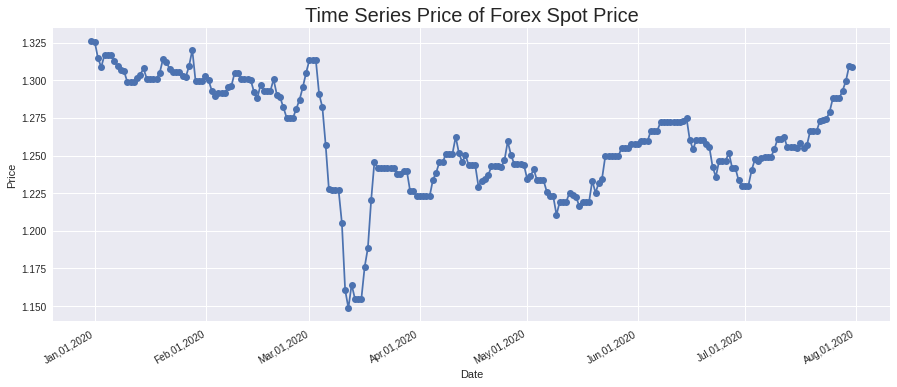

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of Forex Spot Price', size = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

### Plotting Diesel Prices

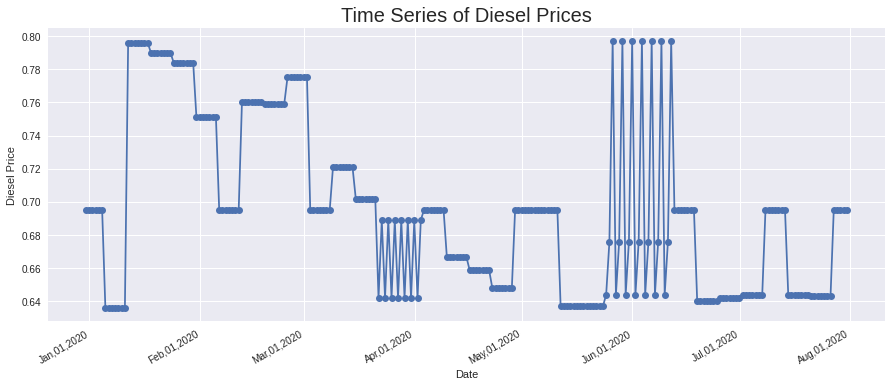

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
diesel = np.array(dataset['Diesel'])
plt.plot_date(dates,diesel, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Diesel Prices', size = 20)
plt.xlabel('Date')
plt.ylabel('Diesel Price')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
diesel_frame = pd.DataFrame(np.concatenate([diesel]), columns= ["Diesel"])



In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_diesel_price = scaler.fit_transform(diesel_frame).reshape(-1,1)


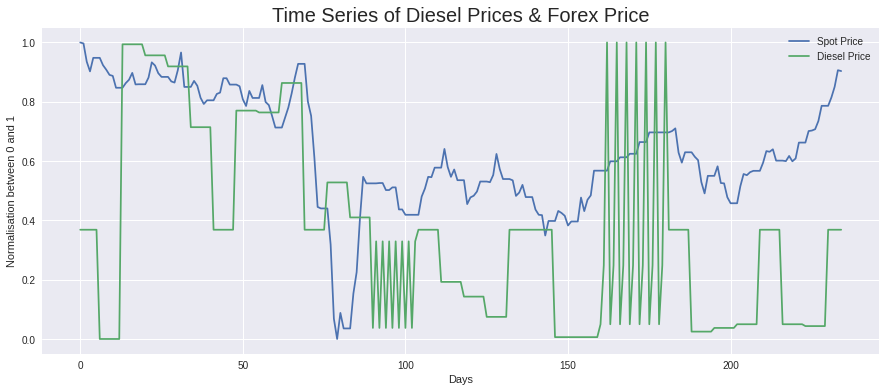

In [ ]:
plt.plot(normalisation_price, label="Spot Price")
plt.plot(normalisation_diesel_price, label="Diesel Price")
dates = np.array(dateFormatting['new_date'])
plt.title('Time Series of Diesel Prices & Forex Price', size = 20)
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Days')
plt.legend() 
plt.show()



In [ ]:
new_dataset = np.hstack((normalisation_diesel_price, normalisation_price))
new_dataset = pd.DataFrame(new_dataset,columns=['Diesel','Price'])
new_dataset.head()

,Diesel,Price
0,0.368447,1.000000
1,0.368447,0.996618
2,0.368447,0.935175
3,0.368447,0.902480
4,0.368447,0.948140


In [ ]:
X = new_dataset[['Diesel']]
Y = new_dataset['Price']

# Split triain & test

In [ ]:
x_train, x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=0, shuffle = False) 

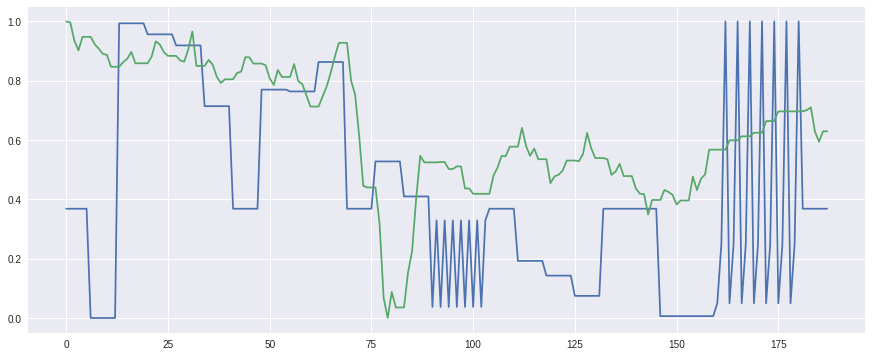

In [ ]:
plt.plot(x_train)
plt.plot(y_train)

# Modelling

In [ ]:
def get_best_fit_train ():
  rcParams['figure.figsize'] = 15,6
  pred = model_lr.coef_ * x_train + model_lr.intercept_
  plt.plot(x_train, label = 'x_train')
  plt.plot(y_train, label = 'y_train')
  plt.plot(pred, label = 'y_pred', color = "red", linewidth=2)
  plt.xlabel('Diesel Price Input')
  plt.ylabel('Spot Price Output')
  plt.legend()

def get_best_fit_test ():
  rcParams['figure.figsize'] = 15,6
  pred = model_lr.coef_ * x_test + model_lr.intercept_
  plt.plot(x_test, label = 'x_test')
  plt.plot(y_test, label = 'y_test')
  plt.plot(pred, label = 'y_pred', color = "red", linewidth=2)
  plt.xlabel('Diesel Price Input')
  plt.ylabel('Spot Price Output')
  plt.legend()


# Performance Metric

In [ ]:
def get_performance_train (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(y_train, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(y_train, model_pred).round(4))
  print('R2_Score:',r2_score(y_train, model_pred).round(4)) 


In [ ]:
def get_performance_test (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(y_test, model_pred).round(4))  
  print('R2_Score:',r2_score(y_test, model_pred).round(4)) 


# Simple Linear Regression

In [ ]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred_train_lr=model_lr.predict(x_train)
pred_test_lr=model_lr.predict(x_test)

Text(0.5, 1.0, 'Where Linear Regression Model Train Results Fall on Actual Spot Price')

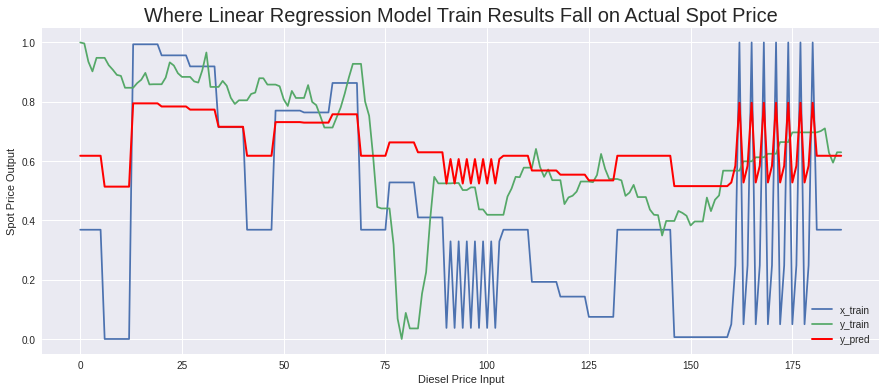

In [ ]:
get_best_fit_train()
plt.title('Where Linear Regression Model Train Results Fall on Actual Spot Price', size = 20)

Text(0.5, 1.0, 'Where Linear Regression Model Test Results Fall on Actual Spot Price')

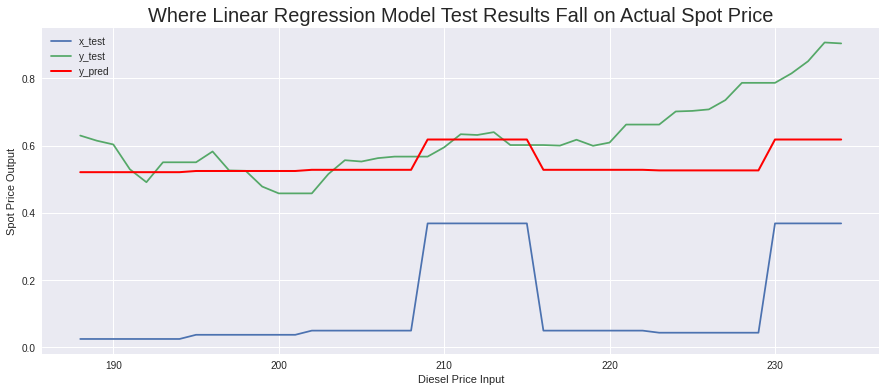

In [ ]:
get_best_fit_test()
plt.title('Where Linear Regression Model Test Results Fall on Actual Spot Price', size = 20)

# Comparison



## Performance Metrics

In [ ]:
print('Train:')
get_performance_train(pred_train_lr)
print('\nTest:')
get_performance_test(pred_test_lr)


Train:
Mean Absolute Error: 0.1395
Mean Squared Error: 0.0365
R2_Score: 0.1879

Test:
Mean Absolute Error: 0.0911
Mean Squared Error: 0.015
R2_Score: -0.2406


## Visual Representation

### Train

In [ ]:
comparison_train = pd.DataFrame({'Actual': y_train, 'Predicted': pred_train_lr})
comparison_train = comparison_train.head(7)
comparison_train.sort_index(inplace=True)
comparison_train

,Actual,Predicted
0,1.000000,0.617891
1,0.996618,0.617891
2,0.935175,0.617891
3,0.902480,0.617891
4,0.948140,0.617891
5,0.948140,0.617891
6,0.948140,0.513764


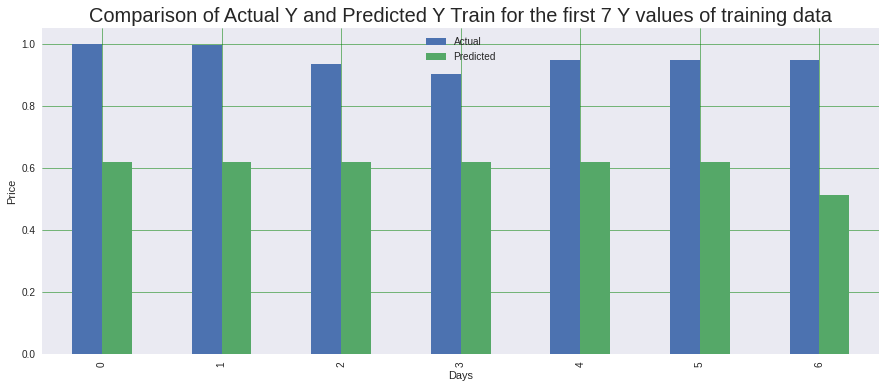

In [ ]:
rcParams['figure.figsize'] = 15,6
comparison_train.plot(kind='bar')
plt.title('Comparison of Actual Y and Predicted Y Train for the first 7 Y values of training data', size=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

### Test

In [ ]:
comparison_test = pd.DataFrame({'Actual': y_test, 'Predicted': pred_test_lr})
comparison_test = comparison_test.tail(7)
comparison_test.sort_index(inplace=True)
comparison_test

,Actual,Predicted
228,0.786359,0.526051
229,0.786359,0.526051
230,0.786359,0.617891
231,0.814543,0.617891
232,0.850620,0.617891
233,0.906426,0.617891
234,0.903608,0.617891


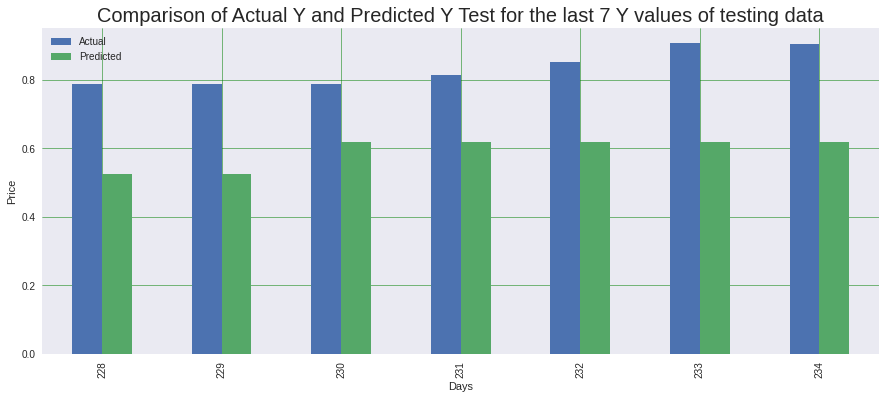

In [ ]:
rcParams['figure.figsize'] = 15,6
comparison_test.plot(kind='bar')
plt.title('Comparison of Actual Y and Predicted Y Test for the last 7 Y values of testing data', size=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Simple Linear Regression Formula

In [ ]:
slope = model_lr.coef_[0]
intercept = model_lr.intercept_
print("formula: y = {0} + {1}x".format(intercept,slope))

formula: y = 0.5137639810983836 + 0.2826105565804639x
